In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, hp, tpe, space_eval

from sklearn.model_selection import KFold, TimeSeriesSplit
import lightgbm as lgb
from time import time
from tqdm import tqdm_notebook

from xgboost import XGBClassifier
import os

import gc
import warnings
warnings.filterwarnings('ignore')

/Users/didi/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



# 导入数据

In [2]:
NROWS = None
# NROWS = 50000

In [3]:
train_identity = pd.read_csv('../input/train_identity.csv', nrows=NROWS)
train_transaction = pd.read_csv('../input/train_transaction.csv', nrows=NROWS)
train = train_transaction.merge(train_identity, how='left', on='TransactionID')

test_identity = pd.read_csv('../input/test_identity.csv', nrows=NROWS)
test_transaction = pd.read_csv('../input/test_transaction.csv', nrows=NROWS)
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

sub = pd.read_csv('../input/sample_submission.csv', nrows=NROWS)

gc.enable()
del train_identity, train_transaction
del test_identity, test_transaction
gc.collect()

print("train.shape:", train.shape)
print("test.shape:", test.shape)
train.head(3)

train.shape: (590540, 434)
test.shape: (506691, 433)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [4]:
target = "isFraud"

In [37]:
train.loc[train["C3"] == 87].shape

(520481, 434)

In [44]:
train['card_str'] = train["card1"].apply(lambda x: str(x)) + "_" + train["card2"].apply(lambda x: str(x)) +\
                "_" + train["card3"].apply(lambda x: str(x)) + "_" + train["card4"].apply(lambda x: str(x)) +\
                "_" + train["card5"].apply(lambda x: str(x)) + "_" + train["card6"].apply(lambda x: str(x))

In [46]:
train['card_str'].nunique()

14893

In [ ]:
当前伪uid在之前的时间被标记为1的cnt数和比例

In [51]:
train.loc[train["isFraud"] ==1, ["TransactionID", "isFraud", "card_str"]].head()

,TransactionID,isFraud,card_str
203,2987203,1,18268_583.0_150.0_visa_226.0_credit
240,2987240,1,13413_103.0_185.0_visa_137.0_credit
243,2987243,1,13413_103.0_185.0_visa_137.0_credit
245,2987245,1,13413_103.0_185.0_visa_137.0_credit
288,2987288,1,16578_545.0_185.0_visa_226.0_credit


In [52]:
train.loc[train["card_str"] == "13413_103.0_185.0_visa_137.0_credit"]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_str
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [38]:
train["C3"].unique()

array([ 0.,  1.,  8.,  3.,  2., 16.,  4.,  9., 10., 12., 11., 13., 14.,
       15., 17., 18., 19., 20., 21., 22., 23.,  5., 24., 25.,  6.,  7.,
       26.])

In [40]:
train.loc[(train["isFraud"] == 1) & (train["C3"] == 1)].shape

(5, 434)

In [41]:
test.loc[test["C3"] == 0].shape

(493779, 433)

In [43]:
len(test) - 493779

12912

In [39]:
train.loc[train["isFraud"] == 1, "C3"].unique()

array([0., 1.])

In [33]:
len(train)

590540

In [34]:
card3_onehot_test.shape

(506691, 133)

In [35]:
len(test)

506691

In [6]:
TransactionDT_min = train['TransactionDT'].min()

In [7]:
TransactionDT_min

86400

In [7]:
train["C1"].max()

4685.0

In [10]:
del_idx = train.loc[train["C1"] >= 3000].index

In [13]:
train.loc[~train.index.isin(del_idx)].shape

(590034, 434)

In [32]:
train.loc[train["V28"]>=1, target].mean()

0.0

In [38]:
train["TransactionDT"].nunique()

573349

In [ ]:
# 平移D10

In [39]:
train["TransactionDT"].max() // (24 * 60 * 60)

182

In [45]:
train["TransactionDT"].max() // (24 * 60 * 60) - train["TransactionDT"].min() // (24 * 60 * 60)

181

In [44]:
test["TransactionDT"].min() // (24 * 60 * 60) - train["TransactionDT"].min() // (24 * 60 * 60)

212

In [42]:
test["TransactionDT"].min()

18403224

In [43]:
test.head(10)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,vis

In [37]:
train[["TransactionDT", "D15"]]

,TransactionDT,D15
0,86400,0.0
1,86401,0.0
2,86469,315.0
3,86499,111.0
4,86506,NaN
5,86510,0.0
6,86522,0.0
7,86529,0.0
8,86535,NaN
9,86536,318.0


In [34]:
test.loc[test["V27"]>=1].shape

(11137, 433)

In [23]:
test.loc[test["V27"]==1].shape

(11103, 433)

In [9]:
train.loc[train["C1"] > 3000].shape

(506, 434)

## 内存优化

In [5]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[: 3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min  and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum()/ 1024**2
    print('Memory usage after optimization is: {:.2f} MB, {:.1f}% reduction'.\
          format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
# %%time
# train = reduce_mem_usage(train)
# test  = reduce_mem_usage(test)

In [7]:
# train.to_csv('../temp/train_temp' + str(NROWS) + '.csv', index=False, header=True)
# test.to_csv('../temp/test_temp'+ str(NROWS) + '.csv', index=False, header=True)

# 特征工程

In [8]:
train = pd.read_csv('../temp/train_temp' + str(NROWS) + '.csv')
test = pd.read_csv('../temp/test_temp'+ str(NROWS) + '.csv')

FileNotFoundError: File b'../temp/train_temp50000.csv' does not exist

In [9]:
print(train.shape)
train.head(3)

(50000, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

## 特征分类: 按特征名分类

## EDA特征

### 当前刷卡信息和前一笔刷卡是否一致

In [10]:
test['card_addr1_P_emaildomain'] = test["card1"].apply(lambda x: str(x)) + "_" + test["card2"].apply(lambda x: str(x)) +\
                "_" + test["card3"].apply(lambda x: str(x)) + "_" + test["card4"].apply(lambda x: str(x)) +\
                "_" + test["card5"].apply(lambda x: str(x)) + "_" + test["card6"].apply(lambda x: str(x)) +\
                "_" + test["addr1"].apply(lambda x: str(x)) + "_" + test["P_emaildomain"].apply(lambda x: str(x))

train['card_addr1_P_emaildomain'] = train["card1"].apply(lambda x: str(x)) + "_" + train["card2"].apply(lambda x: str(x)) +\
                "_" + train["card3"].apply(lambda x: str(x)) + "_" + train["card4"].apply(lambda x: str(x)) +\
                "_" + train["card5"].apply(lambda x: str(x)) + "_" + train["card6"].apply(lambda x: str(x)) +\
                "_" + train["addr1"].apply(lambda x: str(x)) + "_" + train["P_emaildomain"].apply(lambda x: str(x))

shift_feature = []
for i in range(1, 51):
    train["card_addr1_P_emaildomain_" + str(i) + "before"] = train["card_addr1_P_emaildomain"].shift(i)
    test["card_addr1_P_emaildomain_" + str(i) + "before"] = test["card_addr1_P_emaildomain"].shift(i)
    shift_feature.append("card_addr1_P_emaildomain_" + str(i) + "before")

for i in range(-1, -51, -1):
    train["card_addr1_P_emaildomain_" + str(-i) + "after"] = train["card_addr1_P_emaildomain"].shift(i)
    test["card_addr1_P_emaildomain_" + str(-i) + "after"] = test["card_addr1_P_emaildomain"].shift(i)
    shift_feature.append("card_addr1_P_emaildomain_" + str(-i) + "after")
    
def cur_in_window(x):
    cur = x[0]
    window = x[1:]
    cnt = 0
    for item in window:
        if cur == item:
            cnt += 1
    return cnt

train["shift_100_cnt"] = train[["card_addr1_P_emaildomain"] + shift_feature].apply(lambda x: cur_in_window(x), axis=1)
test["shift_100_cnt"]  = test[["card_addr1_P_emaildomain"] + shift_feature].apply(lambda x: cur_in_window(x), axis=1)

train = train.drop(["card_addr1_P_emaildomain"] + shift_feature, axis=1)
test  = test.drop(["card_addr1_P_emaildomain"] + shift_feature, axis=1)

### 刷卡金额shift

In [11]:
def cur_in_window(x):
    cur = x[0]
    window = x[1:]
    cnt = 0
    for item in window:
        if cur == item:
            cnt += 1
    return cnt

for w in [3, 10, 100]:
    
    shift_feature = []
    for i in range(1, w+1):
        train["TransactionAmt_" + str(i) + "before"] = train["TransactionAmt"].shift(i)
        test["TransactionAmt_" + str(i) + "before"] = test["TransactionAmt"].shift(i)
        shift_feature.append("TransactionAmt_" + str(i) + "before")

    for i in range(-1, -(w+1), -1):
        train["TransactionAmt_" + str(-i) + "after"] = train["TransactionAmt"].shift(i)
        test["TransactionAmt_" + str(-i) + "after"] = test["TransactionAmt"].shift(i)
        shift_feature.append("TransactionAmt_" + str(-i) + "after")

    train["Amt_shift_" + str(w) + "_cnt"] = train[["TransactionAmt"] + shift_feature].apply(lambda x: cur_in_window(x), axis=1)
    test["Amt_shift_" + str(w) + "_cnt"]  = test[["TransactionAmt"] + shift_feature].apply(lambda x: cur_in_window(x), axis=1)

    train = train.drop(shift_feature, axis=1)
    test  = test.drop(shift_feature, axis=1)


In [12]:
print(train.shape)
train.head()

(50000, 438)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,shift_100_cnt,Amt_shift_3_cnt,Amt_shift_10_cnt,Amt_shift_100_cnt
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,10

### 缺失值的数量

In [13]:
train['null'] = train.isna().sum(axis=1)
test['null'] = test.isna().sum(axis=1)

### target_encoder

In [14]:
np.random.seed(13)

def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 5 #20
    n_inner_folds = 5 #10
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                               if x[feature] in oof_mean.index else oof_default_inner_mean, axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                               if x[feature] in inner_oof_mean_cv.index else oof_default_mean, axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

In [15]:
train.card5.nunique()

74

In [16]:
target = "isFraud"

In [17]:
# %%time
# # Apply the encoding to training and test data, and preserve the mapping
# categorical_features = ["card2", "card5"]
# impact_coding_map = {}
# for f in categorical_features:
#     print("Impact coding for {}".format(f))
#     train["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(train, f, target)
#     impact_coding_map[f] = (impact_coding_mapping, default_coding)
#     mapping, default_mean = impact_coding_map[f]
#     test["impact_encoded_{}".format(f)] = test.apply(lambda x: mapping[x[f]]
#                                                     if x[f] in mapping else default_mean, axis=1)

### targetEncoder保存中间变量

In [18]:
# train.to_csv('../temp/train_temp' + str(NROWS) + "targetEncoder" + '.csv', index=False, header=True)
# test.to_csv('../temp/test_temp'+ str(NROWS) + "targetEncoder" + '.csv', index=False, header=True)

### 从targetEncoder运行

In [19]:
# train = pd.read_csv('../temp/train_temp' + str(NROWS) + "targetEncoder" + '.csv')
# test = pd.read_csv('../temp/test_temp'+ str(NROWS) + "targetEncoder" + '.csv')

### 时间相关特征(TransactionDT)

In [20]:
def transform_TransactionDT(df):
    START_DATE = '2017-12-01'
    start_date = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['Date'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))

    df['Weekday'] = df['Date'].dt.dayofweek
    df['Hour'] = df['Date'].dt.hour
    df['Day'] = df['Date'].dt.day
    df['Morning'] = (df['Hour'] >= 7) & (df['Hour'] <= 11).astype('int')
    df['Noon'] = (df['Hour'] >=12) & (df['Hour'] <= 18).astype('int')
    df['Evening'] = (df['Hour'] >= 19) & (df['Hour'] <=23).astype('int')
    df['Midnight'] = (df['Hour'] >= 0) & (df['Hour'] <=6).astype('int')
    
    del df['Date']
    
    return df

In [21]:
train = transform_TransactionDT(train)
test = transform_TransactionDT(test)

In [22]:
train['uid'] =  train["addr1"].apply(lambda x: str(x)) + "_" + train["addr2"].apply(lambda x: str(x)) +\
                "_" + train["card1"].apply(lambda x: str(x)) + "_" + train["card2"].apply(lambda x: str(x)) +\
                "_" + train["card3"].apply(lambda x: str(x)) + "_" + train["card4"].apply(lambda x: str(x)) +\
                "_" + train["card5"].apply(lambda x: str(x)) + "_" + train["card6"].apply(lambda x: str(x))

train['uid_Hour_ratio'] = train['uid'].map(train.groupby('uid')['Hour'].apply(lambda x: ((x<6).sum() + 0.24 * 200 ) / (x.shape[0] + 200)))

test['uid'] =  test["addr1"].apply(lambda x: str(x)) + "_" + test["addr2"].apply(lambda x: str(x)) +\
                "_" + test["card1"].apply(lambda x: str(x)) + "_" + test["card2"].apply(lambda x: str(x)) +\
                "_" + test["card3"].apply(lambda x: str(x)) + "_" + test["card4"].apply(lambda x: str(x)) +\
                "_" + test["card5"].apply(lambda x: str(x)) + "_" + test["card6"].apply(lambda x: str(x))

test['uid_Hour_ratio'] = test['uid'].map(test.groupby('uid')['Hour'].apply(lambda x: ((x<6).sum() + 0.24 * 200 ) / (x.shape[0] + 200)))

train = train.drop("uid", axis=1)
test = test.drop("uid", axis=1)

### 金额(TransactionAmt)

In [23]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
train['TransAmtLog'] = np.log(train['TransactionAmt'])
train['TransAmtDemical'] = train['TransactionAmt'].astype('str').str.split('.', expand=True)[1].str.len()

test['TransactionAmt'] = test['TransactionAmt'].astype(float)
test['TransAmtLog'] = np.log(test['TransactionAmt'])
test['TransAmtDemical'] = test['TransactionAmt'].astype('str').str.split('.', expand=True)[1].str.len()

### 金额(TransactionAmt)是否整除的特征

In [24]:
def mod_m(x, m):
    if x%m == 0:
        return 1
    else:
        return 0
    
train['TransactionAmt_mod_1'] = train['TransactionAmt'].apply(lambda x: mod_m(x, 1))
train['TransactionAmt_mod_10'] = train['TransactionAmt'].apply(lambda x: mod_m(x, 10))
train['TransactionAmt_mod_50'] = train['TransactionAmt'].apply(lambda x: mod_m(x, 50))
train['TransactionAmt_mod_100'] = train['TransactionAmt'].apply(lambda x: mod_m(x, 100))

test['TransactionAmt_mod_1'] = test['TransactionAmt'].apply(lambda x: mod_m(x, 1))
test['TransactionAmt_mod_10'] = test['TransactionAmt'].apply(lambda x: mod_m(x, 10))
test['TransactionAmt_mod_50'] = test['TransactionAmt'].apply(lambda x: mod_m(x, 50))
test['TransactionAmt_mod_100'] = test['TransactionAmt'].apply(lambda x: mod_m(x, 100))

### 金额(TransactionAmt)出现的次数

In [25]:
train['TransactionAmt_count_full'] = train['TransactionAmt'].map(pd.concat([train['TransactionAmt'], test['TransactionAmt']], ignore_index=True).value_counts(dropna=False))
test['TransactionAmt_count_full'] = test['TransactionAmt'].map(pd.concat([test['TransactionAmt'], test['TransactionAmt']], ignore_index=True).value_counts(dropna=False))


In [26]:
np.corrcoef(train["isFraud"], train['uid_Hour_ratio'])[0][1]

0.022940210066556502

### ProductCD

In [27]:
train.ProductCD.unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

### card特征提取

In [28]:
# # 对card特征 Label Encoding
# card = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

# for f in tqdm_notebook(card):
#     lbl = LabelEncoder()
#     temp = pd.DataFrame(train[f].astype(str).append(test[f].astype(str)))
#     lbl.fit(temp[f])
#     train[f + '_endoce'] = lbl.transform(list(train[f].astype(str)))
#     test[f + '_endoce'] = lbl.transform(list(test[f].astype(str))) 

In [29]:
def get_sub(x, idx):
    try:
        return str(x)[idx]
    except:
        return "-1"

for idx in [-1, -2, -3, -4, -5]:
    train["card1" + "_sub_" + str(idx)] = train["card1"].apply(lambda x: get_sub(x, idx))
    test["card1" + "_sub_" + str(idx)]  = test["card1"].apply(lambda x: get_sub(x, idx))

### target encoding

In [30]:
feature = 'card1'
temp = train.groupby([feature])[target].sum().reset_index()
temp.index = temp[feature]
temp = temp.drop(feature, axis=1)
faeture_map = temp.to_dict()[target]
train[feature + "_target_cnt"] = train[feature].map(faeture_map)
test[feature + "_target_cnt"] = test[feature].map(faeture_map)

In [31]:
# card1是类别型特征,对card1的字段进行提取

train["card1_len"] = train["card1"].apply(lambda x: len(str(x)))
test["card1_len"]  = test["card1"].apply(lambda x: len(str(x)))

train["card1_first"] = train["card1"].apply(lambda x: str(x)[0])
test["card1_first"]  = test["card1"].apply(lambda x: str(x)[0])

# card2特征提取
# train["card2_first"] = train["card2"].apply(lambda x: str(x)[0])
# test["card2_first"]  = test["card2"].apply(lambda x: str(x)[0])

# train["card2_second"] = train["card2"].apply(lambda x: str(x)[1])
# test["card2_second"]  = test["card2"].apply(lambda x: str(x)[1])

# train["card2_last"] = train["card2"].apply(lambda x: str(x)[2])
# test["card2_last"]  = test["card2"].apply(lambda x: str(x)[2])


In [32]:
# 是否缺失的标记
train["card1_na"] = 0
train.loc[train["card1"].isna(), "card1_na"] = 1
test["card1_na"] = 0
test.loc[test["card1"].isna(), "card1_na"] = 1

train["card2_na"] = 0
train.loc[train["card2"].isna(), "card2_na"] = 1
test["card2_na"] = 0
test.loc[test["card2"].isna(), "card2_na"] = 1

# train["card3_na"] = 0
# train.loc[train["card3"].isna(), "card3_na"] = 1
# test["card3_na"] = 0
# test.loc[test["card3"].isna(), "card3_na"] = 1

# train["card4_na"] = 0
# train.loc[train["card4"].isna(), "card4_na"] = 1
# test["card4_na"] = 0
# test.loc[test["card4"].isna(), "card4_na"] = 1

train["card5_na"] = 0
train.loc[train["card5"].isna(), "card5_na"] = 1
test["card5_na"] = 0
test.loc[test["card5"].isna(), "card5_na"] = 1

# train["card6_na"] = 0
# train.loc[train["card6"].isna(), "card6_na"] = 1
# test["card6_na"] = 0
# test.loc[test["card6"].isna(), "card6_na"] = 1

In [33]:
# card字段拼接的统计

train['card_str'] = train["card1"].apply(lambda x: str(x)) + "_" + train["card2"].apply(lambda x: str(x)) +\
                "_" + train["card3"].apply(lambda x: str(x)) + "_" + train["card4"].apply(lambda x: str(x)) +\
                "_" + train["card5"].apply(lambda x: str(x)) + "_" + train["card6"].apply(lambda x: str(x))

test['card_str'] = test["card1"].apply(lambda x: str(x)) + "_" + test["card2"].apply(lambda x: str(x)) +\
                "_" + test["card3"].apply(lambda x: str(x)) + "_" + test["card4"].apply(lambda x: str(x)) +\
                "_" + test["card5"].apply(lambda x: str(x)) + "_" + test["card6"].apply(lambda x: str(x))

train['card_count_full'] = train['card_str'].map(pd.concat([train['card_str'], test['card_str']], ignore_index=True).value_counts(dropna=False))
test['card_count_full'] = test['card_str'].map(pd.concat([test['card_str'], test['card_str']], ignore_index=True).value_counts(dropna=False))


In [34]:
train['TransactionAmt_to_std_card_str'] = train['TransactionAmt'] / train.groupby(['card_str'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card_str'] = test['TransactionAmt'] / test.groupby(['card_str'])['TransactionAmt'].transform('std')

train['TransactionAmt_to_mean_card_str'] = train['TransactionAmt'] / train.groupby(['card_str'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card_str'] = test['TransactionAmt'] / test.groupby(['card_str'])['TransactionAmt'].transform('mean')

train['TransactionAmt_to_sum_card_str'] = train['TransactionAmt'] / train.groupby(['card_str'])['TransactionAmt'].transform('sum')
test['TransactionAmt_to_sum_card_str'] = test['TransactionAmt'] / test.groupby(['card_str'])['TransactionAmt'].transform('sum')


In [35]:
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))

train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))

train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))

train['card6_count_full'] = train['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
test['card6_count_full'] = test['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))

In [36]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card2'] = train['TransactionAmt'] / train.groupby(['card2'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('mean')

train['TransactionAmt_to_mean_card3'] = train['TransactionAmt'] / train.groupby(['card3'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card3'] = test['TransactionAmt'] / test.groupby(['card3'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')

train['TransactionAmt_to_mean_card5'] = train['TransactionAmt'] / train.groupby(['card5'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card6'] = train['TransactionAmt'] / train.groupby(['card6'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card5'] = test['TransactionAmt'] / test.groupby(['card5'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card6'] = test['TransactionAmt'] / test.groupby(['card6'])['TransactionAmt'].transform('mean')

In [37]:
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card2'] = train['TransactionAmt'] / train.groupby(['card2'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('std')

train['TransactionAmt_to_std_card3'] = train['TransactionAmt'] / train.groupby(['card3'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card3'] = test['TransactionAmt'] / test.groupby(['card3'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['TransactionAmt_to_std_card5'] = train['TransactionAmt'] / train.groupby(['card5'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card6'] = train['TransactionAmt'] / train.groupby(['card6'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card5'] = test['TransactionAmt'] / test.groupby(['card5'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card6'] = test['TransactionAmt'] / test.groupby(['card6'])['TransactionAmt'].transform('std')

In [38]:
train['TransactionAmt_to_sum_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('sum')
train['TransactionAmt_to_sum_card2'] = train['TransactionAmt'] / train.groupby(['card2'])['TransactionAmt'].transform('sum')
test['TransactionAmt_to_sum_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('sum')
test['TransactionAmt_to_sum_card2'] = test['TransactionAmt'] / test.groupby(['card2'])['TransactionAmt'].transform('sum')

train['TransactionAmt_to_sum_card3'] = train['TransactionAmt'] / train.groupby(['card3'])['TransactionAmt'].transform('sum')
train['TransactionAmt_to_sum_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('sum')
test['TransactionAmt_to_sum_card3'] = test['TransactionAmt'] / test.groupby(['card3'])['TransactionAmt'].transform('sum')
test['TransactionAmt_to_sum_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('sum')

train['TransactionAmt_to_sum_card5'] = train['TransactionAmt'] / train.groupby(['card5'])['TransactionAmt'].transform('sum')
train['TransactionAmt_to_sum_card6'] = train['TransactionAmt'] / train.groupby(['card6'])['TransactionAmt'].transform('sum')
test['TransactionAmt_to_sum_card5'] = test['TransactionAmt'] / test.groupby(['card5'])['TransactionAmt'].transform('sum')
test['TransactionAmt_to_sum_card6'] = test['TransactionAmt'] / test.groupby(['card6'])['TransactionAmt'].transform('sum')

In [39]:
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

In [40]:
train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

### card svd特征

In [41]:
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

def get_dc_feature(df_train, df_test, n_comp=12, used_features=None):
    """
    构造分解特征
    """
    if not used_features:
        used_features = df_test.columns
        
    train = df_train.copy()
    test  = df_test.copy()    
        
    # tSVD
#     tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
#     tsvd_results_train = tsvd.fit_transform(train[used_features])
#     tsvd_results_test = tsvd.transform(test[used_features])

    # PCA
    pca = PCA(n_components=n_comp, random_state=420)
    pca2_results_train = pca.fit_transform(train[used_features])
    pca2_results_test = pca.transform(test[used_features])

#     # ICAz
#     ica = FastICA(n_components=n_comp, random_state=420)
#     ica2_results_train = ica.fit_transform(train[used_features])
#     ica2_results_test = ica.transform(test[used_features])

#     # GRP
#     grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
#     grp_results_train = grp.fit_transform(train[used_features])
#     grp_results_test = grp.transform(test[used_features])

#     # SRP
#     srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
#     srp_results_train = srp.fit_transform(train[used_features])
#     srp_results_test = srp.transform(test[used_features])
    
    # Append decomposition components to datasets
    for i in range(1, n_comp + 1):
        train['pca_' + str(i)] = pca2_results_train[:, i - 1]
        test['pca_' + str(i)] = pca2_results_test[:, i - 1]

#         train['ica_' + str(i)] = ica2_results_train[:, i - 1]
#         test['ica_' + str(i)] = ica2_results_test[:, i - 1]

#         train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
#         test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

#         train['grp_' + str(i)] = grp_results_train[:, i - 1]
#         test['grp_' + str(i)] = grp_results_test[:, i - 1]

#         train['srp_' + str(i)] = srp_results_train[:, i - 1]
#         test['srp_' + str(i)] = srp_results_test[:, i - 1]

    return train, test

print(train.shape, test.shape)
used_features = ['card1', 'card2','card3', 'card5']

train[used_features] = train[used_features].fillna(-1.0)
test[used_features]  = test[used_features].fillna(-1.0)

train, test = get_dc_feature(train, test, n_comp=3, used_features=used_features)
print(train.shape, test.shape)

(50000, 502) (50000, 501)
(50000, 505) (50000, 504)


### address
both are for purchaser, addr1 as billing region, addr2 as billing country

In [42]:
train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

train['addr2_count_full'] = train['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
test['addr2_count_full'] = test['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')

### distance

In [43]:
train["dist1_plus_dist2"]  = train["dist1"] + train["dist2"]
train["dist1_minus_dist2"] = train["dist1"] - train["dist2"]
train["dist1_times_dist2"]  = train["dist1"] * train["dist2"]
train["dist1_divides_dist2"] = train["dist1"] / train["dist2"]

test["dist1_plus_dist2"]  = test["dist1"] + test["dist2"]
test["dist1_minus_dist2"] = test["dist1"] - test["dist2"]
test["dist1_times_dist2"]  = test["dist1"] * test["dist2"]
test["dist1_divides_dist2"] = test["dist1"] / test["dist2"]

### 邮箱

In [44]:
def transform_email(df):
    for col in ['P_emaildomain', 'R_emaildomain']:
        col1 = col.replace('domain', '_suffix')
        df[col1] = df[col].str.rsplit('.', expand=True).iloc[:, -1]
        
        col2 = col.replace('domain', 'Corp')
        df[col2] = df[col]
        df.loc[df[col].isin(['gmail.com', 'gmail']), col2] = 'Google'
        df.loc[df[col].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk', 'yahoo.co.jp', 
                             'yahoo.de', 'yahoo.fr', 'yahoo.es', 'yahoo.com.mx', 
                             'ymail.com']), col2] = 'Yahoo'
        df.loc[df[col].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 'hotmail.es', 
                             'hotmail.co.uk', 'hotmail.de', 'outlook.es', 'live.com', 'live.fr', 
                             'hotmail.fr']), col2] = 'Microsoft'
        df.loc[df[col].isin(['aol.com', 'verizon.net']), col2] = 'Verizon'
        df.loc[df[col].isin(['att.net', 'sbcglobal.net', 'bellsouth.net']), col2] = 'AT&T'
        df.loc[df[col].isin(['icloud.com', 'mac.com', 'me.com']), col2] = 'Apple'
        df.loc[df[col2].isin(df[col2].value_counts()[df[col2].value_counts() <= 1000].index), col2] = 'Others'
    
    return df

In [45]:
train = transform_email(train)
test = transform_email(test)

In [46]:
# train['P_email']=(train['P_emaildomain']=='xmail.com')
# train['R_email']=(train['R_emaildomain']=='xmail.com')
# test['P_email']=(test['P_emaildomain']=='xmail.com')
# test['R_email']=(test['R_emaildomain']=='xmail.com')

### C1-C14

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.


### D1-D15
timedelta, such as days between previous transaction, etc.

### M1-M9
match, such as names on card and address, etc.

In [47]:
MFeatures = ["M1","M2","M3","M4","M5","M6","M7","M8","M9"]
for feature in MFeatures:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))


### Vxxx
Vesta engineered rich features, including ranking, counting, and other entity relations.

### id相关特征

In [48]:
# # lastest_browser

# a = np.zeros(train.shape[0])
# train["lastest_browser"] = a
# a = np.zeros(test.shape[0])
# test["lastest_browser"] = a

# def browser(df):
#     df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
#     df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
#     return df

# train=browser(train)
# test=browser(test)

In [49]:
def transform_id_cols(df):
#     df['id_01_cut'] = pd.cut(df['id_01'], bins=[-100, -30, -20, -10, -5, 0])
    
    df['id_05_d'] = df['id_05']
    df['id_05_d'].where(df[df['id_05_d'].notnull()]['id_05_d'] == 0, 1, inplace=True)
    
#     df['id_06_cut'] = pd.cut(df['id_06'], bins=[-100, -10, -5, 0])
    df['id_06_d'] = df['id_06']
    df['id_06_d'].where(df[df['id_06_d'].notnull()]['id_06_d'] == 0, 1, inplace=True)
    
    # Dealing with id_30
    df['id_30_count'] = df['id_30'].map(df['id_30'].value_counts(dropna=False))
    df['System'] = df['id_30'].astype('str').str.split('.', expand=True)[0].str.split('_', expand=True)[0]
    df['SystemCorp'] = df['System'].str.split(expand=True)[0]
    
    # Dealing with id_31
    df['LastestBrowser'] = df['id_31']
    df.loc[df['LastestBrowser'].isin(['samsung browser 7.0', 'opera 53.0', 'mobile safari 10.0', 'chrome 63.0 for android', 
                                       'google search application 49.0', 'firefox 60.0', 'edge 17.0', 'chrome 69.0', 
                                       'chrome 67.0 for android', 'chrome 64.0', 'chrome 63.0 for ios', 'chrome 65.0', 
                                       'chrome 64.0 for android', 'chrome 64.0 for ios', 'chrome 66.0', 
                                       'chrome 65.0 for android', 'chrome 65.0 for ios', 'chrome 66.0 for android', 
                                       'chrome 66.0 for ios']), 'LastestBrowser'] = 1
    df.loc[df['LastestBrowser'].str.len() > 1, 'LastestBrowser'] = 0
    
    df['id_31_count'] = df['id_31'].map(df['id_31'].value_counts(dropna=False))
    
    df['MSBrowser'] = df['id_31'].str.contains('edge|ie|microsoft', case=False) * 1
    df['AppleBrowser'] = df['id_31'].str.contains('safari', case=False) * 1
    df['GoogleBrowser'] = df['id_31'].str.contains('chrome', case=False) * 1
    
    df['BrowserType'] = df['id_31']
    df.loc[df['BrowserType'].str.contains('samsung', case=False, na=False), 'BrowserType'] = 'Samsung'
    df.loc[df['BrowserType'].str.contains('safari', case=False, na=False), 'BrowserType'] = 'Apple'
    df.loc[df['BrowserType'].str.contains('chrome|google', case=False, na=False), 'BrowserType'] = 'Google'
    df.loc[df['BrowserType'].str.contains('firefox', case=False, na=False), 'BrowserType'] = 'Mozilla'
    df.loc[df['BrowserType'].str.contains('edge|ie|microsoft', case=False, na=False, regex=True), 'BrowserType'] = 'Microsoft'
    df.loc[df['BrowserType'].isin(df['BrowserType'].value_counts()\
                                      [df['BrowserType'].value_counts()< 1000].index), ['BrowserType']] = 'other'
    
    # Dealing with id_33
    df['id_33_count'] = df['id_33'].map(df['id_33'].value_counts(dropna=False))
    df['DisplaySize'] = df['id_33'].str.split('x', expand=True)[0].astype('float')\
                            * df['id_33'].str.split('x', expand=True)[1].astype('float')
    df['DisplaySize'].replace(0, np.nan, inplace=True)
    df['DisplaySize'] = (df['DisplaySize'] / df['DisplaySize'].min()).round(0)
    
    # Try easy combining
    for feature in ['id_02__id_20', 'id_13__id_17', 'id_02__D8', 'D11__DeviceInfo', 
                    'DeviceInfo__P_emaildomain', 'card2__dist1', 'card1__card5', 
                    'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:
        f1, f2 = feature.split('__')
        df[feature] = df[f1].astype(str) + '_' + df[f2].astype(str)
    for col in ['id_30', 'id_31', 'id_33', 'DeviceInfo']:
        df[col + '_DeviceTpye'] = train[col] + '_' + train['DeviceType']
           
    return df

In [50]:
train = transform_id_cols(train)
test  = transform_id_cols(test)

### DeviceType

In [51]:
train.DeviceType.unique()

array([nan, 'mobile', 'desktop'], dtype=object)

### DeviceInfo

In [52]:
def transform_DeviceInfo(df):
    df['DeviceCorp'] = df['DeviceInfo']
    df.loc[df['DeviceInfo'].str.contains('HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceCorp'] = 'HUAWEI'
    df.loc[df['DeviceInfo'].str.contains('OS', na=False, regex=False), 'DeviceCorp'] = 'APPLE'
    df.loc[df['DeviceInfo'].str.contains('Idea|TA', case=False, na=False), 'DeviceCorp'] = 'Lenovo'
    df.loc[df['DeviceInfo'].str.contains('Moto|XT|Edison', case=False, na=False), 'DeviceCorp'] = 'Moto'
    df.loc[df['DeviceInfo'].str.contains('MI|Mi|Redmi', na=False), 'DeviceCorp'] = 'Mi'
    df.loc[df['DeviceInfo'].str.contains('VS|LG|EGO', na=False), 'DeviceCorp'] = 'LG'
    df.loc[df['DeviceInfo'].str.contains('ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceCorp'] = 'ALCATEL'
    df.loc[df['DeviceInfo'].str.contains('ONE A', na=False, regex=False), 'DeviceCorp'] = 'ONEPLUS'
    df.loc[df['DeviceInfo'].str.contains('OPR6', na=False, regex=False), 'DeviceCorp'] = 'HTC'
    df.loc[df['DeviceInfo'].str.contains('Nexus|Pixel', case=False, na=False, regex=True), 'DeviceCorp'] = 'google'
    df.loc[df['DeviceInfo'].str.contains('STV', na=False, regex=False), 'DeviceCorp'] = 'blackberry'
    df.loc[df['DeviceInfo'].str.contains('ASUS', case=False, na=False, regex=False), 'DeviceCorp'] = 'ASUS'
    df.loc[df['DeviceInfo'].str.contains('BLADE', case=False, na=False, regex=False), 'DeviceCorp'] = 'ZTE'
    
    df['DeviceCorp'] = df['DeviceInfo'].astype('str').str.split(':', expand=True)[0].\
                                str.split('-', expand=True)[0].str.split(expand=True)[0]
    
    df.loc[df['DeviceInfo'].isin(['rv', 'SM', 'GT', 'SGH']), 'DeviceCorp'] = 'SAMSUNG'
    df.loc[df['DeviceInfo'].str.startswith('Z', na=False), 'DeviceCorp'] = 'ZTE'
    df.loc[df['DeviceInfo'].str.startswith('KF', na=False), 'DeviceCorp'] = 'Amazon'
    
    for i in ['D', 'E', 'F', 'G']:
        df.loc[df['DeviceInfo'].str.startswith(i, na=False), 'DeviceCorp'] = 'SONY'

    minority = df['DeviceCorp'].value_counts()[df['DeviceCorp'].value_counts() < 100].index
    df.loc[df['DeviceCorp'].isin(minority), 'DeviceCorp'] = 'Other'
    df['DeviceCorp'] = df['DeviceCorp'].str.upper()
    
    return df

In [53]:
train = transform_DeviceInfo(train)
test  = transform_DeviceInfo(test)

### 类别型变量labelEncoder

In [54]:
target = "isFraud"
# Label Encoding
for f in tqdm_notebook([feature for feature in train.columns if feature != target]):
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = LabelEncoder()
        temp = pd.DataFrame(train[f].astype(str).append(test[f].astype(str)))
        lbl.fit(temp[f])
        train[f] = lbl.transform(list(train[f].astype(str)))
        test[f] = lbl.transform(list(test[f].astype(str))) 

### 构造特征

In [55]:
def transform_number(df):
    df['id_02_log'] = np.log10(df['id_02'])
    
    df['C5_d'] = df['C5']
    df['C5_d'].where(df['C5'] == 0, 1, inplace=True)
    
    df['D8_mul_D9'] = df['D8'] * df['D9']
    
    df['TransAmt_mul_dist1'] = df['TransactionAmt'] * df['dist1']
    df['TransAmt_per_TransDT'] = df['TransactionAmt'] * 24 * 60 * 60 / df['TransactionDT']
    
    return df

In [56]:
train = transform_number(train)
test  = transform_number(test)

### 交叉特征

The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) 
and transactions posterior to it with either user account, email address or billing address 
directly linked to these attributes as fraud too. 
If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).

### 原交叉特征

In [57]:
for feature in tqdm_notebook(['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 
                              'P_emaildomain__C2', 
                              'P_emaildomain__card1', 'P_emaildomain__card2',
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 
                              'addr1__card1', 'card2__card4', 'card4__card6'
                             ]):

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

### 增加后的交叉特征

In [58]:
# for feature in tqdm_notebook(['P_emaildomain__card1', 'P_emaildomain__card2', 'P_emaildomain__card3', 'P_emaildomain__card4', 'P_emaildomain__card5', 'P_emaildomain__card6',
#                 'R_emaildomain__card1', 'R_emaildomain__card2', 'R_emaildomain__card3', 'R_emaildomain__card4', 'R_emaildomain__card5', 'R_emaildomain__card6',
#                 'addr1__card2', 'addr1__card3', 'addr1__card4', 'addr1__card5', 'addr1__card6',
#                 'addr2__card3', 'addr2__card4', 'addr2__card5', 'addr2__card6',
#                 'card3__card4', 'card3__card5', 'card3__card6',
#                 'card4__card5', 'card4__card6',
#                 'card5__card6',
#                 'id_02__id_20', 'id_02__D8', 
#                 'card2__dist1', 'card2__id_20',
#                 'P_emaildomain__DeviceInfo', 'P_emaildomain__C2',
#                 'D11__DeviceInfo']):

#     f1, f2 = feature.split('__')
#     train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
#     test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

#     le = LabelEncoder()
#     le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
#     train[feature] = le.transform(list(train[feature].astype(str).values))
#     test[feature] = le.transform(list(test[feature].astype(str).values))

### 高阶交叉特征

In [59]:
for feature in tqdm_notebook([
                              'P_emaildomain__card1__card2', 'addr1__card1__card2'
                             ]):

    f1, f2, f3 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str) + '_' + train[f3].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str) + '_' + test[f3].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

# 缺失值填充

# 线下验证

### 按照时间划分数据集

In [60]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,...,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,shift_100_cnt,Amt_shift_3_cnt,Amt_shift_10_cnt,Amt_shift_100_cnt,null,Weekday,Hour,Day,Morning,Noon,Evening,Midnight,uid_Hour_ratio,TransAmtLog,TransAmtDemical,TransactionAmt_mod_1,TransactionAmt_mod_10,TransactionAmt_mod_50,TransactionAmt_mod_100,TransactionAmt_count_full,card1_sub_-1,card1_sub_-2,card1_sub_-3,card1_sub_-4,card1_sub_-5,card1_target_cnt,card1_len,card1_first,card1_na,card2_na,card5_na,card_str,card_count_full,TransactionAmt_to_std_card_str,TransactionAmt_to_mean_card_str,TransactionAmt_to_sum_card_str,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card2,TransactionAmt_to_mean_card3,TransactionAmt_to_mean_card4,TransactionAmt_to_mean_card5,TransactionAmt_to_mean_card6,TransactionAmt_to_std_card1,TransactionAmt_to_std_card2,TransactionAmt_to_std_card3,TransactionAmt_to_std_card4,TransactionAmt_to_std_card5,TransactionAmt_to_std_card6,TransactionAmt_to_sum_card1,TransactionAmt_to_sum_card2,TransactionAmt_to_sum_card3,TransactionAmt_to_sum_card4,TransactionAmt_to_sum_card5,TransactionAmt_to_sum_card6,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,pca_1,pca_2,pca_3,addr1_count_full,addr2_count_full,D15_to_mean_addr1,D15_to_std_addr1,dist1_plus_dist2,dist1_minus_dist2,dist1_times_dist2,dist1_divides_dist2,P_email_suffix,P_emailCorp,R_email_suffix,R_emailCorp,M1_count_full,M2_count_full,M3_count_full,M4_count_full,M5_count_full,M6_count_full,M7_count_full,M8_count_full,M9_count_full,id_05_d,id_06_d,id_30_count,System,SystemCorp,LastestBrowser,id_31_count,MSBrowser,AppleBrowser,GoogleBrowser,BrowserType,id_33_count,DisplaySize,id_02__id_20,id_13__id_17,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_30_DeviceTpye,id_31_DeviceTpye,id_33_DeviceTpye,DeviceInfo_DeviceTpye,DeviceCorp,id_02_log,C5_d,D8_mul_D9,TransAmt_mul_dist1,TransAmt_per_TransDT,P_emaildomain__C2,P_emaildomain__card1,P_emaildomain__card2,card2__card4,card4__card6,P_emaildomain__card1__card2,addr1__card1__card2
0,2987000,

In [61]:
test.head(3)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,...,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,shift_100_cnt,Amt_shift_3_cnt,Amt_shift_10_cnt,Amt_shift_100_cnt,null,Weekday,Hour,Day,Morning,Noon,Evening,Midnight,uid_Hour_ratio,TransAmtLog,TransAmtDemical,TransactionAmt_mod_1,TransactionAmt_mod_10,TransactionAmt_mod_50,TransactionAmt_mod_100,TransactionAmt_count_full,card1_sub_-1,card1_sub_-2,card1_sub_-3,card1_sub_-4,card1_sub_-5,card1_target_cnt,card1_len,card1_first,card1_na,card2_na,card5_na,card_str,card_count_full,TransactionAmt_to_std_card_str,TransactionAmt_to_mean_card_str,TransactionAmt_to_sum_card_str,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card2,TransactionAmt_to_mean_card3,TransactionAmt_to_mean_card4,TransactionAmt_to_mean_card5,TransactionAmt_to_mean_card6,TransactionAmt_to_std_card1,TransactionAmt_to_std_card2,TransactionAmt_to_std_card3,TransactionAmt_to_std_card4,TransactionAmt_to_std_card5,TransactionAmt_to_std_card6,TransactionAmt_to_sum_card1,TransactionAmt_to_sum_card2,TransactionAmt_to_sum_card3,TransactionAmt_to_sum_card4,TransactionAmt_to_sum_card5,TransactionAmt_to_sum_card6,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,pca_1,pca_2,pca_3,addr1_count_full,addr2_count_full,D15_to_mean_addr1,D15_to_std_addr1,dist1_plus_dist2,dist1_minus_dist2,dist1_times_dist2,dist1_divides_dist2,P_email_suffix,P_emailCorp,R_email_suffix,R_emailCorp,M1_count_full,M2_count_full,M3_count_full,M4_count_full,M5_count_full,M6_count_full,M7_count_full,M8_count_full,M9_count_full,id_05_d,id_06_d,id_30_count,System,SystemCorp,LastestBrowser,id_31_count,MSBrowser,AppleBrowser,GoogleBrowser,BrowserType,id_33_count,DisplaySize,id_02__id_20,id_13__id_17,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_30_DeviceTpye,id_31_DeviceTpye,id_33_DeviceTpye,DeviceInfo_DeviceTpye,DeviceCorp,id_02_log,C5_d,D8_mul_D9,TransAmt_mul_dist1,TransAmt_per_TransDT,P_emaildomain__C2,P_emaildomain__card1,P_emaildomain__card2,card2__card4,card4__card6,P_emaildomain__card1__card2,addr1__card1__card2
0,3663549,184

In [62]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test_X = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [63]:
# del train
# gc.collect()

In [64]:
X.shape, test_X.shape

((50000, 563), (50000, 563))

### lightgbm参数

In [65]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

### 参数优化
- todo

### 删除不重要的特征

In [66]:
# feature_keep = 505

# all_data = lgb.Dataset(X, label=y)
# feature_clf  = lgb.train(params, all_data, num_boost_round = 800, valid_sets = [all_data], verbose_eval=100) 
# feature_importances = pd.DataFrame()
# feature_importances['feature'] = X.columns
# feature_importances['score'] = feature_clf.feature_importance()
# feature_importances = feature_importances.sort_values(by="score", ascending=False)
# feature_used = list(feature_importances.head(feature_keep)['feature'])

# X = X[feature_used]
# test_X = test_X[feature_used]

In [67]:
# drop_features = ["id_31"]
# # drop_features = ["id_31", "D15", "D10"]
# X = X.drop(drop_features, axis=1)
# test_X = test_X.drop(drop_features, axis=1)

In [68]:
# cols_to_drop=['V300','V309','V111','C3','V124','V106','V125','V315','V134','V102','V123','V316','V113',
#               'V136','V305','V110','V299','V289','V286','V318','V103','V304','V116','V29','V284','V293',
#               'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
#               'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120']


# print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

# X = X.drop(cols_to_drop, axis=1)
# test_X = test_X.drop(cols_to_drop, axis=1)    

In [69]:
folds = TimeSeriesSplit(n_splits=2)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
#     clf = lgb.train(params, trn_data, num_boost_round = 10000, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500)
    clf = lgb.train(params, trn_data, num_boost_round = 10000, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_0']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.926862
[200]	valid_0's auc: 0.936496
[300]	valid_0's auc: 0.942226
[400]	valid_0's auc: 0.947778
[500]	valid_0's auc: 0.9506
[600]	valid_0's auc: 0.952197
[700]	valid_0's auc: 0.953604
[800]	valid_0's auc: 0.954744
[900]	valid_0's auc: 0.955452
[1000]	valid_0's auc: 0.955691
[1100]	valid_0's auc: 0.955931
[1200]	valid_0's auc: 0.956066
[1300]	valid_0's auc: 0.956075
[1400]	valid_0's auc: 0.956038
[1500]	valid_0's auc: 0.955914
[1600]	valid_0's auc: 0.95582
[1700]	valid_0's auc: 0.955741
[1800]	valid_0's auc: 0.955607
Early stopping, best iteration is:
[1328]	valid_0's auc: 0.956145
Fold 1 finished in 0:00:35.038167
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.937113
[200]	valid_0's auc: 0.943166
[300]	valid_0's auc: 0.945616
[400]	valid_0's auc: 0.948551
[500]	valid_0's auc: 0.951774
[600]	valid_0's auc: 0.952902
[700]	vali

In [70]:
train.shape[0]

50000

- 三折timeseries: mean auc
- 原始:           0.9032
- 增加shift特征后: 0.9036
- 增加金额的count: 0.9032
- 增加shift金额后: 0.9033
- card1_target_cnt: 0.95765

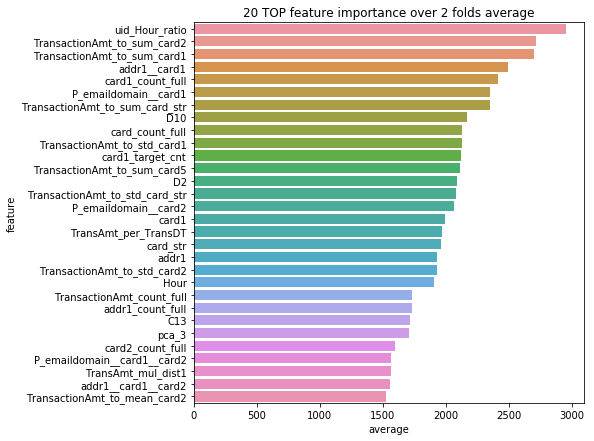

In [71]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(7, 7))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(30), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

## 模型预测

In [53]:
PREDICT = False
if PREDICT:
    # clf right now is the last model, trained with 80% of data and validated with 20%
    best_iter = clf.best_iteration
    print("best_iteration: ", best_iter)
    # clf = lgb.LGBMClassifier(**params, num_boost_round=int(best_iter * 1.1))
    # clf.fit(X, y)

    all_data = lgb.Dataset(X, label=y)
    all_clf  = lgb.train(params, all_data, num_boost_round = int(best_iter * 1.20), valid_sets = [all_data], verbose_eval=100) 

    # sub['isFraud'] = clf.predict_proba(test_X)[:, 1]
    sub['isFraud'] = all_clf.predict(test_X)
    sub.to_csv('ieee_cis_fraud_detection_v6.csv', index=False)

### xbg模型

In [54]:
if PREDICT:
    sub = pd.read_csv('../input/sample_submission.csv', nrows=NROWS)

    n_fold = 6
    folds = KFold(n_splits=n_fold,shuffle=True)

    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    xgb_sub=sub.copy()
    xgb_sub['isFraud'] = 0

    #fill in -111 for categoricals
    X = X.fillna(-111)
    test_X = test_X.fillna(-111)

    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        xgb = XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
                        learning_rate=0.05, max_delta_step=0, max_depth=9,
                        min_child_weight=1, missing=-111, n_estimators=500, n_jobs=1,
                        nthread=None, objective='binary:logistic', random_state=0,
                        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                        subsample=0.9, verbosity=1
        )

        X_train_, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train_, y_valid = y.iloc[train_index], y.iloc[valid_index]
        xgb.fit(X_train_,y_train_)
        del X_train_,y_train_
        pred=xgb.predict_proba(test_X)[:,1]
        val=xgb.predict_proba(X_valid)[:,1]
        del xgb, X_valid
        print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
        del val,y_valid
        xgb_sub['isFraud'] = xgb_sub['isFraud']+pred/n_fold
        del pred
        gc.collect()
        
    xgb_sub.to_csv('sub_xgb.csv', index=False)

# 结果记录

- file/线下mean/线下fold5/线上
- ieee_cis_fraud_detection_v2.csv/0.92431/0.93523/0.9416


# 实验

- 不带交叉特征: 0.9021, 0.924753
- 原交叉特征:  0.90323, 0.927644
- 增加交叉特征: 0.902691, 0.924993
- 优化交叉特征: 0.90404, 0.927612
- 高阶交叉特征1 2个: 0.90372, 0.928267 最优
- 高阶交叉特征2 10个: 0.902636, 0.925677
- 高阶交叉特征2 5个: 0.903707, 0.926686

- 删除不重要的特征
- 保留全部:          0.90372,  0.928267
- feature_keep=400: 0.90240,  0.927373
- feature_keep=480: 0.90302,  0.926563
- feature_keep=180: 0.90218,  0.926139
- feature_keep=505: 0.904084, 0.926456


- 删除特征
- https://www.kaggle.com/iasnobmatsu/xgb-model-with-feature-engineering

- 保留全部:            0.9037,  0.9283
- 删除D15:            0.9038,   0.9254
- 删除D15和D10:       0.9036,   0.9264    
- 删除D15,D10,id_13:  0.9038,   0.9271

- 增加svd等特征
- 原始:                   0.9037,  0.9283
- card +15个特征:         0.9016,  0.9241
- card +3个pca特征:       0.9022, 0.9255


- 增加 TransactionAmt_to_mean_card 特征
- 原始, card1和card4:                   0.9037, 0.9283
- 增加card2, card3, card5, card6:       0.9032, 0.9274         


- card1 特征挖掘
- 不增加:                                0.9020, 0.9261     
- 增加card1_len和card1_first:            0.9037, 0.9293
- 增加card1_len和card1_first, 去掉pca:    0.9034, 0.9274

- card2 特征挖掘
- 不增加:                                0.9031, 0.9276
- 增加card2_first, second, last:         0.90204, 0.9242    

- card每个值的缺失情况:
- 未加特征之前:    0.9035, 0.9290
- 加特征之后:      

- P_email
- 增加前: 0.9032, 0.9298
- 增加后: 0.9033, 0.9275

- lastest_browser
- 增加前: 0.9032, 0.9298
- 增加后: 0.9013, 0.9252

- cols_to_drop
- 删除前: 0.9032, 0.9298
- 删除后: 0.9033, 0.9275

- card字段拼接统计 (10万条样本)
- 增加前: 0.9128, 0.9093
- 增加后: 0.9129, 0.9107

- card字段拼接统计 (5万条样本)
- 增加前: 0.9032, 0.9298
- 增加后: 0.9030, 0.9284

- TransactionAmt_to_std_card_str和TransactionAmt_to_mean_card_str:
- 增加前: 0.9030, 0.9284
- 增加后: 0.9022, 0.9285


- 对card特征 Label Encoding
- 增加前: 0.9022, 0.9285
- 增加后: 0.9014, 0.9267

- 金额(TransactionAmt)是否整除的特征
- 原始:   0.9021, 0.9277
- 增加后: 0.9017, 0.9290

- target encoder
- "card2", "card5":           0.9177, 0.9306
- "card1", "card2", "card5":  0.9482, 0.9251

- 增加TransactionAmt_to_sum_card_str
- 原始:   0.9019, 0.9287
- 增加后: 0.9017, 0.9287

- 增加TransactionAmt_to_sum_card特征
- 原始带"card2", "card5"target encoder:   0.9177, 0.9306
- 增加后带"card2", "card5"target encoder:  0.9172, 0.9313
- 不带"card2", "card5"target encoder:     0.9019, 0.9287

In [55]:
# # prob特征
# ## msno context features
# dummy_feat = ['source_system_tab', 'source_screen_name', 'source_type']
# concat = train.drop('target', axis=1).append(test.drop('id', axis=1))

# for feat in dummy_feat:
#     feat_dummies = pd.get_dummies(concat[feat])
#     feat_dummies.columns = ['msno_%s_'%feat + '%s'%col for col in feat_dummies.columns]
#     feat_dummies['msno'] = concat['msno'].values
#     feat_dummies = feat_dummies.groupby('msno').mean()
#     feat_dummies['msno'] = feat_dummies.index
#     member = member.merge(feat_dummies, on='msno', how='left')

# train_temp = train.merge(member, on='msno', how='left')
# test_temp = test.merge(member, on='msno', how='left')

# train['msno_source_system_tab_prob'] = train_temp[[col for col in train_temp.columns if 'source_system_tab' in col]].apply(lambda x: \
#         x['msno_source_system_tab_%d'%x['source_system_tab']], axis=1)
# test['msno_source_system_tab_prob'] = test_temp[[col for col in test_temp.columns if 'source_system_tab' in col]].apply(lambda x: \
#         x['msno_source_system_tab_%d'%x['source_system_tab']], axis=1)



# # prob特征
# dummy_feat = ['card2']
# concat = train.drop(target, axis=1).append(test)

# for feat in dummy_feat:
#     feat_dummies = pd.get_dummies(concat[feat])
#     feat_dummies.columns = ['card5_%s_'%feat + '%s'%col for col in feat_dummies.columns]
#     feat_dummies['card5'] = concat['card5'].values
#     feat_dummies = feat_dummies.groupby('card5').mean()
#     feat_dummies['card5'] = feat_dummies.index
#     member = member.merge(feat_dummies, on='card5', how='left')

# train_temp = train.merge(member, on='card5', how='left')
# test_temp = test.merge(member, on='card5', how='left')

# train['prob_card5|card2'] = train_temp[[col for col in train_temp.columns if 'card2' in col]].apply(lambda x: \
#         x['card5_card2_%d'%x['card2']], axis=1)
# test['prob_card5|card2'] = test_temp[[col for col in test_temp.columns if 'card2' in col]].apply(lambda x: \
#         x['card5_card2_%d'%x['card2']], axis=1)

KeyError: "labels ['target'] not contained in axis"

In [ ]:
# _count_full_feature
# category_features=["ProductCD","P_emaildomain",
#                    "R_emaildomain","M1","M2","M3","M4","M5","M6","M7","M8","M9","DeviceType","DeviceInfo","id_12",
#                    "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
#                    "id_25","id_26","id_27","id_28","id_29","id_30","id_32","id_34", 'id_36'
#                    "id_37","id_38"]
# for c in category_features:
#     train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
#     test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))